In [102]:
#for fashion mnist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [103]:
#for mnist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [33]:
#for cifar 10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 77.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [104]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

mps


In [105]:
#for mnist and fashion mnist
#binary classification task
#predict correct class labels
#minimax on f (classifier)
#implementation details from https://arxiv.org/pdf/1710.10571 and https://arxiv.org/pdf/1906.00331

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import csv


eta_x = 5e-5  #theta lr
eta_y = 5e-2 #x_adv lr
inner_steps = 1  #1 for gda, 20 for gdmax
gamma = 1.3 #adversarial perturbation {0.4, 1.3}

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #input (batch_size, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=8) #3 conv layers, mnist grayscale, (batch_size, 32, 21, 21)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6) #(batch_size, 64, 16, 16)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5) #(batch_size, 128, 12, 12)
        self.fc = nn.Linear(128*12*12, num_classes) 

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.flatten(start_dim=1)
        return self.fc(x)

#wasserstein robust loss
def wrm_loss(model, x, y, gamma, inner_steps):
    x_adv = x.clone() #x_adv = alpha in orig paper -> inner max var
    x_adv = x_adv.detach().requires_grad_(True)
    for step in range(inner_steps):
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y, reduction='none')#cross entropy loss, l(f(x'),y)
        penalty = gamma*((x_adv-x)**2).flatten(start_dim=1).sum(dim=1) #gamma||x'-x||^2
        total = (loss-penalty).sum()
        grad = torch.autograd.grad(total, x_adv, create_graph=True)[0]
        x_adv = x_adv+eta_y*grad
    logits = model(x_adv)
    return F.cross_entropy(logits, y) #min loss wrt theta



In [ ]:
#for cifar
#binary classification task
#predict correct class labels
#minimax on f (classifier)
#implementation details from https://arxiv.org/pdf/1710.10571 and https://arxiv.org/pdf/1906.00331

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import csv

eta_x = 5e-5  #theta lr
eta_y = 1e-4 #x_adv lr
inner_steps = 1  #1 for gda, 20 for gdmax
gamma = 0.4 #adversarial perturbation {0.4, 1.3}

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #(batch_size, 1, 28, 28)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc = nn.Linear(128*4*4, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x) 
        x = x.view(x.size(0), -1)
        return self.fc(x)

#wasserstein robust loss
def wrm_loss(model, x, y, gamma, inner_steps):
    x_adv = x.clone() #x_adv = alpha in orig paper -> inner max var
    x_adv = x_adv.detach().requires_grad_(True)
    for step in range(inner_steps):
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y, reduction='none')#cross entropy loss, l(f(x'),y)
        penalty = gamma*((x_adv-x)**2).flatten(start_dim=1).sum(dim=1) #gamma||x'-x||^2
        total = (loss-penalty).sum()
        grad = torch.autograd.grad(total, x_adv, create_graph=True)[0]
        x_adv = x_adv+eta_y*grad
    logits = model(x_adv)
    return F.cross_entropy(logits, y) #min loss wrt theta



In [106]:
base_model = Classifier()
initial_state = base_model.state_dict()

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x) #forwards pass outputs
            preds = logits.argmax(dim=1) #predict class -> max logit value
            correct += (preds == y).sum().item() #num correct preds
            total += y.size(0) #total num preds
    model.train()
    return correct/total #accuracy

def run_training(inner_steps, mode, eta_x, epochs, gamma, initial_state):
    theta = Classifier().to(device)
    theta.load_state_dict(initial_state) 
    opt_theta = optim.SGD(theta.parameters(), lr=eta_x) #learning rate optimizer
    #scheduler = torch.optim.lr_scheduler.StepLR(opt_theta, step_size=10, gamma=0.5) #reduce learning rate every 10 steps
    csv_file = f"{mode}.csv"
    with open(csv_file, mode="w", newline="") as log_file:
        writer = csv.writer(log_file)
        writer.writerow(["Epoch", "Loss", "Test Accuracy", "Gradient Calls"])
        total_grad_calls = 0
        if mode == "GDA":
            epochs = 30
        else:
            epochs = 15 #gdmax too slow
        max_batches = 50 
        for epoch in range(epochs):
            for i, (x, y) in enumerate(train_loader):
                if i >= max_batches:
                    break
                x, y = x.to(device), y.to(device)
                loss = wrm_loss(theta, x, y, gamma=gamma, inner_steps=inner_steps)
                opt_theta.zero_grad()
                loss.backward() #downhill gradient
                opt_theta.step() #theta update step
                total_grad_calls += inner_steps+1

            acc = evaluate(theta, test_loader)
            print(f"{mode} -> Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}, Grad Calls: {total_grad_calls}")
            writer.writerow([epoch + 1, loss.item(), acc, total_grad_calls])
            #scheduler.step()

for mode in ["GDA", "GDmax"]:
    if mode == "GDA":
        inner_steps = 1#og paper - gda has 1 inner step
        eta_x = 5e-5
        epochs = 40
    else:
        inner_steps = 20#sinha paper
        eta_x = 1e-4 
        epochs = 20

    run_training(inner_steps, mode, eta_x, epochs, gamma, initial_state)


#note: GDmax runs much slow (20min) than GDA (2min), which makes sense


GDA -> Epoch 1, Loss: 2.2851, Test Acc: 0.1348, Grad Calls: 100
GDA -> Epoch 2, Loss: 2.2840, Test Acc: 0.1730, Grad Calls: 200
GDA -> Epoch 3, Loss: 2.2853, Test Acc: 0.2048, Grad Calls: 300
GDA -> Epoch 4, Loss: 2.2778, Test Acc: 0.2343, Grad Calls: 400
GDA -> Epoch 5, Loss: 2.2752, Test Acc: 0.2698, Grad Calls: 500
GDA -> Epoch 6, Loss: 2.2685, Test Acc: 0.3032, Grad Calls: 600
GDA -> Epoch 7, Loss: 2.2627, Test Acc: 0.3305, Grad Calls: 700
GDA -> Epoch 8, Loss: 2.2547, Test Acc: 0.3608, Grad Calls: 800
GDA -> Epoch 9, Loss: 2.2520, Test Acc: 0.3894, Grad Calls: 900
GDA -> Epoch 10, Loss: 2.2476, Test Acc: 0.4185, Grad Calls: 1000
GDA -> Epoch 11, Loss: 2.2355, Test Acc: 0.4439, Grad Calls: 1100
GDA -> Epoch 12, Loss: 2.2334, Test Acc: 0.4664, Grad Calls: 1200
GDA -> Epoch 13, Loss: 2.2298, Test Acc: 0.4854, Grad Calls: 1300
GDA -> Epoch 14, Loss: 2.2251, Test Acc: 0.5039, Grad Calls: 1400
GDA -> Epoch 15, Loss: 2.2240, Test Acc: 0.5221, Grad Calls: 1500
GDA -> Epoch 16, Loss: 2.214

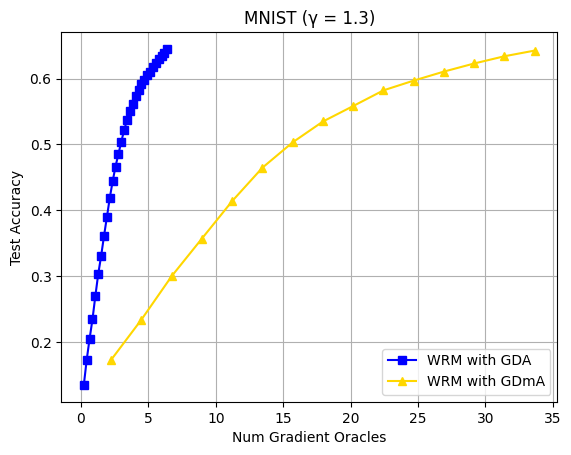

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

gda = pd.read_csv("GDA.csv")
gdmax = pd.read_csv("GDmax.csv")
batch_size = 128
batches_per_epoch = 60000//batch_size
gda["Grad Calls"] = gda["Gradient Calls"]/batches_per_epoch #scaling used in paper
gdmax["Grad Calls"] = gdmax["Gradient Calls"]/batches_per_epoch

plt.figure()
plt.plot(gda["Grad Calls"], gda["Test Accuracy"], label="WRM with GDA", marker='s', color='blue')
plt.plot(gdmax["Grad Calls"], gdmax["Test Accuracy"], label="WRM with GDmA", marker='^', color='gold')
plt.xlabel("Num Gradient Oracles")
plt.ylabel("Test Accuracy")
plt.title("MNIST (γ = 1.3)")
plt.grid(True)
plt.legend()
plt.show()

#plot differences - doing only 5 epochs but paper does until convergence
#try to run more epoch of gda to get to converge
